# Imports

We're going to be using Google's Tensorflow package: 
https://www.tensorflow.org/tutorials

We're using an API wrapper for Tensorflow called ktrain. It's absolutely fabulous because it really abstracts the whole deep learning process into a workflow so easy, even a computational social scientist can do it:
https://github.com/amaiya/ktrain

In [1]:
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
import time
import pandas as pd
from keras.preprocessing.text import Tokenizer
import pickle
import json
import glob
import json
import numpy as np

2.7.0


#Set your google colab runtime to use GPU, a must for deep learning!
Runtime > Change Runtime Type > GPU

Let's download our data. For this project, we're going to be using data from Kaggle. Whenever you're on the hunt for some data to play around with in the predictive modeling word, Kaggle's database of datasets is a great place to poke around. Our data comes from Kaggle's News Category database:
https://www.kaggle.com/rmisra/news-category-dataset/version/2

The syntax to fetch a file from a URL and save it to your Google Drive is:
```
!wget <URL> -P <COLAB PATH>
```




In [2]:
!wget http://128.138.93.164/news_category_trainingdata.json -P /content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification

--2022-01-07 00:41:55--  http://128.138.93.164/news_category_trainingdata.json
Connecting to 128.138.93.164:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78875614 (75M) [application/json]
Saving to: ‘/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/news_category_trainingdata.json.1’

news_category_train 100%[===================>]  75.22M  45.7MB/s    in 1.6s    

2022-01-07 00:41:57 (45.7 MB/s) - ‘/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification/news_category_trainingdata.json.1’ saved [78875614/78875614]



In [3]:
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification"
DATA_DIR = "%s" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

I took the liberty of altering the data structure of the .jsonl to a json format that is native with pandas, so we can load it in with one line. If you're curious, our data structure here is a collection of json entries, one per line. We can load it to a pandas dataframe like so.

```
json_file = open('News_Category_Dataset_v2.json', 'r')
columns = ['category', 'headline', 'authors', 'link', 'short_description', 'date']

training_data = pd.DataFrame(columns = columns)

for i, aline in enumerate(json_file):
  parsed_json = json.loads(aline)
  for acolumn in columns:
    training_data = training_data.append(pd.Series(name=i, dtype='float64'))
    training_data[acolumn][i] = parsed_json[acolumn]
  if i % 1000 == 0:
      print(i)
```



In [4]:
reviews = pd.read_json('%s/news_category_trainingdata.json' % DATA_DIR)

Every time pandas handles a data format in a one-liner, an angel gets its wings. It's a beautiful, albeit rare thing.

#Preparing the Data

In [5]:
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


Most machine learning tools in Python accept one field/column/string. So we have to merge our two text column. Let's separate it with a space.

In [6]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

The first thing we need to do is prepare the data. Specifically, we have a categorical column that we want to turn into a "is this article healthy living?" column. That is, when an article is about healthy living, it should have a 1, when it's anything else, it should be a 0.

In [7]:
reviews[reviews['category'].str.contains("HEALTHY LIVING")]

,category,headline,authors,link,short_description,date,combined_text
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...
...,...,...,...,...,...,...,...
124913,HEALTHY LIVING,Why You Need Both a 'Bouncer' and a 'Bartender...,"Elizabeth Grace Saunders, ContributorFounder, ...",https://www.huffingtonpost.com/entry/happy-hea...,Instead of judging whether you made the right ...,2014-04-18,Why You Need Both a 'Bouncer' and a 'Bartender...
124914,HEALTHY LIVING,How Video Games Can Improve Dialogue on Mental...,"Mona Shattell, Contributornurse researcher",https://www.huffingtonpost.com/entry/mental-il...,While there are strong arguments for the games...,2014-04-18,How Video Games Can Improve Dialogue on Mental...
124925,HEALTHY LIVING,Wake-Up Calls Inspired My Change From Overdriv...,"Jane Shure, ContributorLeadership Coach, Psych...",https://www.huffingtonpost.com/entry/wake-up-c...,My wake-up call marching orders were clear: No...,2014-04-18,Wake-Up Calls Inspired My Change From Overdriv...
124950,HEALTHY LIVING,Loving a Narcissist Without Losing Yourself,"Nancy Colier, ContributorPsychotherapist, inte...",https://www.huffingtonpost.com/entry/narcissis...,It is very difficult for some people to see an...,2014-04-18,Loving a Narcissist Without Losing Yourself It...


A quick pandas search soes that we have 6.7 articles that are about healthy living. The following line of code uses numpy's where functionality to help us recode the data. When "Healthy Living" appears in the "category" column, we'll label the "healthy" column with a 1. When it doesn't, it'll be 0.

In [8]:
reviews['healthy'] = np.where((reviews['category'] == 'HEALTHY LIVING'), 1, 0)

In [9]:
reviews['healthy'].describe()

count    200853.000000
mean          0.033328
std           0.179492
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: healthy, dtype: float64

Yes! We're seeing the 1's where we'd expect.

So our data is very unbalanced. We have 6694 articles about healthly living, and about 194k that are not. If we give a machine learning algorithm this much negative evidence, it'll end up tuning itself to label everything as 0's more often than not. So, let's balance our data we have 6694 articles that are healthy living, and 6694 that are not!

In [10]:
sample_amount = 6694

healthy = reviews[reviews['healthy'] == 1]
not_healthy = reviews[reviews['healthy'] == 0].sample(n=sample_amount)

In [11]:
review_sample = pd.concat([healthy,not_healthy])

In [12]:
review_sample.describe()

,healthy
count,13388.000000
mean,0.500000
std,0.500019
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


A mean of .5 means these datasets are now perfectly balanced! And the N = 2*6694!

# Test, Tune and Save Models

In [13]:
target_names = ['NOT HEALTHY LIVING','HEALTHY LIVING']

In [14]:
#tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=target_names)
# #other models you might try 'roberta-base', 'bert-base-uncased', 'distilroberta-base'
#we're going to use 'distilbert-base-uncased' for our model here
#ktrain lets us try some of the pretrained models available on huggingface
#you can browse all the models here: https://huggingface.co/transformers/pretrained_models.html
#some work, some dont, try at your own risk.

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [15]:
train, val, preprocess = texts_from_df(review_sample, 'combined_text', label_columns=['healthy'], val_df=None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['not_healthy', 'healthy']
        not_healthy  healthy
98183           0.0      1.0
31029           0.0      1.0
127918          1.0      0.0
146082          1.0      0.0
90982           0.0      1.0
['not_healthy', 'healthy']
        not_healthy  healthy
33922           0.0      1.0
110078          1.0      0.0
35338           0.0      1.0
105196          1.0      0.0
51771           1.0      0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 29
	95percentile : 59
	99percentile : 70


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 29
	95percentile : 59
	99percentile : 70


In [16]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

In [17]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
753/753 [==============================] - 420s 537ms/step - loss: 0.6670 - accuracy: 0.5920
Epoch 2/6
753/753 [==============================] - 407s 541ms/step - loss: 0.3725 - accuracy: 0.8474
Epoch 3/6
753/753 [==============================] - 407s 540ms/step - loss: 0.4886 - accuracy: 0.7234
Epoch 4/6
753/753 [==============================] - 407s 540ms/step - loss: 0.7101 - accuracy: 0.4933
Epoch 5/6
753/753 [==============================] - 407s 541ms/step - loss: 0.7027 - accuracy: 0.5015
Epoch 6/6
753/753 [==============================] - 407s 540ms/step - loss: 0.8946 - accuracy: 0.4941


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


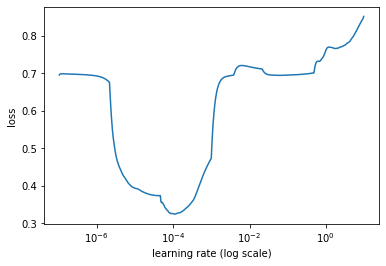

In [18]:
learner.lr_plot()

In [19]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
754/754 [==============================] - 424s 546ms/step - loss: 0.3829 - accuracy: 0.8342 - val_loss: 0.3082 - val_accuracy: 0.8678
Epoch 2/12
754/754 [==============================] - 413s 543ms/step - loss: 0.2455 - accuracy: 0.9065 - val_loss: 0.3129 - val_accuracy: 0.8678
Epoch 00002: early stopping
Weights from best epoch have been loaded into model.


In [20]:
learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)

In [21]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)
predictor.save("%s/distilbertmodel_predictor")

In [22]:
validation = learner.validate(val_data=val, print_report=True)

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       655
           1       0.86      0.89      0.87       684

    accuracy                           0.87      1339
   macro avg       0.87      0.87      0.87      1339
weighted avg       0.87      0.87      0.87      1339



Hey, that's a pretty good set of performance metrics. Interpreted, that means for every 100 articles that we would target for healthy living, 84 of them would actually be healthy living. Recall here means that of all the possible healthy living articles that we could have gotten, we get 90% of all possible. Not too bad!

# Inspecting the drivers of prediction

No matter what the supervised machine learning model, you always want to peak under the hood to see what features are driving prediction. That is, what words sway the outcome of the prediction. It's harder to inspect a neural network. Because all of the layers of a neural network aren't really interpretable to the human eye. 

Currently, the best practice I've found is a little tool Explainable AI:
https://alvinntnu.github.io/python-notes/nlp/ktrain-tutorial-explaining-predictions.html

In [23]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Let's go ahead and make a little set of test documents to check out

In [24]:
test_docs = [
'Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.',
'Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.',
'What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.',
'Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.',
'Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The district attorney described the woman who said former Gov. Andrew Cuomo had groped her as “credible,” but added that proving her allegation would be difficult.',
'A Film Captures Jewish Life in a Polish Town Before the Nazis Arrived. A documentary based on a home movie shot by an American in 1938 provides a look at the vibrancy of a Jewish community in Europe just before the Holocaust.' 
             ]

In [25]:
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is healthy is %s' % probs[1])
  print(text)

---------------------------
The probability this is healthy is 0.9599182
Stress May Be Your Heart’s Worst Enemy Psychological stress activates the fear center in the brain, setting into motion a cascade of reactions that can lead to heart attacks and strokes.
---------------------------
The probability this is healthy is 0.92785066
Exercising to Slim Down? Try Getting Bigger. It’s high time for women to reclaim the real strength behind exercise.
---------------------------
The probability this is healthy is 0.91612244
What Are Your Food Resolutions for the New Year? Join us for the Eat Well Challenge starting in January.
---------------------------
The probability this is healthy is 0.80050933
Why We All Need to Have More Fun. Prioritizing fun may feel impossible right now. But this four-step plan will help you rediscover how to feel more alive.
---------------------------
The probability this is healthy is 0.007621423
Cuomo Will Not Be Prosecuted in Groping Case, Albany D.A. Says. The

*These* are pretty obvious examples, but it works exactly as expected!

In [26]:
predictor.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

But you can see, this algorithm is far from perfect. Here you can see that it's probably got too high of an emphasis on the word "healthy."

So what would I do next? Well, given that it's over reacting to worrds like health and equitable, I'd try introducing more negative examples into the data, times where healthy is used outside of health and wellness news. We can do this by changing our sample from 50/50 to something like 20/80, but of course, the more documents we process, the longer this model is going to take to make!